# **<center>EDA**

### Import packages

In [1]:
import os

from dotenv import load_dotenv

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from minisom import MiniSom

from tqdm import tqdm

#### Set Preferences

In [6]:
pd.set_option('display.max_columns', None)
plt.style.use('dark_background')

#### Set Directory

In [3]:
# Load in the dotenv variables
load_dotenv()

project_path = os.getenv('Project_Path')[2:78]

# Change notebook directory back one so that it can acess the data
os.chdir(project_path)

### Load the data

In [4]:
# Load the cleaned data from data wrangling
data = pd.read_csv('./data/interim/wrangled', low_memory = False)
# Load in the loan_status column for use
y = pd.read_csv('./data/raw/loan.csv',low_memory = False)['loan_status']

In [7]:
data.head(3)

,loan_amnt,term,grade,annual_inc,pymnt_plan,inq_last_6mths,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,dti_joint,tot_cur_bal,open_acc_6m,il_util,max_bal_bc,inq_last_12m,emp_type_Accountant,emp_type_Admin,emp_type_Analyst,emp_type_Assistant,emp_type_Clergy,emp_type_Clerk,emp_type_Designer,emp_type_Director,emp_type_Education,emp_type_Executive,emp_type_Healer,emp_type_Manager,emp_type_Operator,emp_type_Technical,emp_type_Vol,home_ownership_OTHER,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_major_purchase,purpose_other,purpose_small_business,purpose_wedding,addr_state_AL,addr_state_CO,addr_state_DC,addr_state_FL,addr_state_IL,addr_state_KS,addr_state_ME,addr_state_MS,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NV,addr_state_NY,addr_state_SC,addr_state_TX,addr_state_VA
0,-1.156460,-0.654724,0.763889,-0.789014,-0.003357,0.305877,-0.335522,-0.145932,1.201140,-1.373775,-0.97077,-0.415561,0.302329,-0.107149,0.576897,-0.023957,-0.843347,-0.103891,-0.139209,-0.116273,-0.088306,-0.109205,-0.104843,-0.157505,-0.147428,-0.039637,-0.077757,-0.052789,-0.196448,-0.186479,-0.180873,-0.245189,-0.435078,-0.169413,-0.395006,-0.172517,-0.016276,1.2214,-0.768632,1.431317,1.817653,-0.140912,-0.225373,-0.108777,-0.051496,-0.113061,-0.147149,-0.052423,-0.271536,-0.204067,-0.094934,-0.024331,-0.065744,-0.02324,-0.036428,-0.069732,-0.119254,-0.301818,-0.110158,-0.295217,-0.174612
1,-1.452829,1.527360,-0.314193,-0.696292,-0.003357,4.312132,-0.335522,-0.679268,-1.912396,-1.796028,-0.97077,-0.426398,-3.540893,-0.107149,0.576897,-0.023957,-0.843347,-0.103891,-0.139209,-0.116273,-0.088306,-0.109205,-0.104843,-0.157505,-0.147428,-0.039637,-0.077757,-0.052789,-0.196448,-0.186479,-0.180873,-0.245189,-0.435078,-0.169413,-0.395006,-0.172517,-0.016276,1.2214,1.301013,-0.698657,-0.550160,-0.140912,-0.225373,-0.108777,-0.051496,-0.113061,-0.147149,-0.052423,-0.271536,-0.204067,-0.094934,-0.024331,-0.065744,-0.02324,-0.036428,-0.069732,-0.119254,-0.301818,-0.110158,-0.295217,-0.174612
2,-1.464683,-0.654724,-0.468204,-0.970563,-0.003357,1.307441,-0.335522,-0.622684,1.821333,-1.289324,-0.97077,-0.315809,0.302329,-0.107149,0.576897,-0.023957,-0.843347,-0.103891,-0.139209,-0.116273,-0.088306,-0.109205,-0.104843,-0.157505,-0.147428,-0.039637,-0.077757,-0.052789,-0.196448,-0.186479,-0.180873,-0.245189,-0.435078,-0.169413,-0.395006,-0.172517,-0.016276,1.2214,-0.768632,-0.698657,-0.550160,-0.140912,-0.225373,9.193151,-0.051496,-0.113061,-0.147149,-0.052423,-0.271536,4.900357,-0.094934,-0.024331,-0.065744,-0.02324,-0.036428,-0.069732,-0.119254,-0.301818,-0.110158,-0.295217,-0.174612


In [8]:
# Create a loop over all the different attack types
for col in data.columns:
    # Print out the attack types in bullet format to make the next section easier
    print(f"- {col}")

- loan_amnt
- term
- grade
- annual_inc
- pymnt_plan
- inq_last_6mths
- pub_rec
- revol_bal
- revol_util
- total_acc
- initial_list_status
- last_pymnt_amnt
- last_credit_pull_d
- collections_12_mths_ex_med
- mths_since_last_major_derog
- dti_joint
- tot_cur_bal
- open_acc_6m
- il_util
- max_bal_bc
- inq_last_12m
- emp_type_Accountant
- emp_type_Admin
- emp_type_Analyst
- emp_type_Assistant
- emp_type_Clergy
- emp_type_Clerk
- emp_type_Designer
- emp_type_Director
- emp_type_Education
- emp_type_Executive
- emp_type_Healer
- emp_type_Manager
- emp_type_Operator
- emp_type_Technical
- emp_type_Vol
- home_ownership_OTHER
- home_ownership_RENT
- verification_status_Source Verified
- verification_status_Verified
- purpose_credit_card
- purpose_major_purchase
- purpose_other
- purpose_small_business
- purpose_wedding
- addr_state_AL
- addr_state_CO
- addr_state_DC
- addr_state_FL
- addr_state_IL
- addr_state_KS
- addr_state_ME
- addr_state_MS
- addr_state_ND
- addr_state_NE
- addr_state_NH


## **Basic Analysis**

While it may be possible to intuit many of the column names from the dataset it is important to define all of these columns.

- **loan_amnt:** The amount the loan was for
- **term**: The length of the loan
- **grade:** The grade that Lending Club assigns the borrower to set an interest rate and give the investors some information.
- **annual_inc:** The income of the borrower per year. This also includes joint income if the borrower has another person that is contributing to the application
- **pymnt_plan:** Indicates whether or not the borrower is on a payment plan to get back to being up to date on their payments.
- **inq_last_6mths:** The number of inquiries in the last 6 months excluding auto and mortgage inquiries.
- **pub_rec:** The number of derogatory public records that the borrower has
- **revol_bal:** Total balance for the borrower's revolving credit line
- **revol_util:** The amount of credit the borrower is using compared to the revolving limit
- **total_acc:** total number of accounts on the borrower's file
- **initial_list_status:** The type of loan that it is values are 0 and 1
- **last_pymnt_amnt:** The amount that the borrower paid the last time a payment was made.
- **last_credit_pull_d:** The last time that lending club had to pull the borrower's credit for the loan. I filled in missing values as the same month as the issue date
- **collections_12_mths_ex_med:** The number of collections in the last 12 months exluding medical
- **mths_since_last_major_derog:** The amount of months since the last 90-day rating or worse rating
- **dti_joint:** Binary variable that is higher when the dti number is joint.
- **tot_cur_bal:** Total current balance of all accounts
- **open_acc_6m:** The number of open trade accounts in the last 6 months
- **il_util:** Ratio of tot_cur_bal to the credit limit on installment accounts
- **max_bal_bc:** Maximum balance owed on all revolving accounts 
- **inq_last_12m:** The number of inquiries into the borrower in the last 12 months excluding auto and mortgage inquiries.
- **emp_type_...:** Dummy Variables representing the profession of the borrower.
- **home_ownership_...:** Dummy Variables representing the home_ownership situation of the borrower.
- **verification_status_...:** Dummy variables representing Lending Clubs level of verification for the borrower
- **purpose_...:** Dummy variables that are the reason that the borrower took out the loan. Higher value indicates yes
- **addr_state_...:** Dummy variables that higher if the borrower is from that state. The three dots at the end represent the initials of the state

In [16]:
# Create a loop over all the different attack types
for type in y.unique():
    # Print out the attack types in bullet format to make the next section easier
    print(f"- {type}")

- Fully Paid
- Charged Off
- Current
- Default
- Late (31-120 days)
- In Grace Period
- Late (16-30 days)
- Does not meet the credit policy. Status:Fully Paid
- Does not meet the credit policy. Status:Charged Off
- Issued


- **Fully Paid:** The loan has be fully repaid on time in its entirety
- **Charged Off:** The loan has not been fully repaid and has been written off as not fully recoverable
- **Current:** The borrower is up to date on all the payments but the term of the loan has not expired and there are payments remaining
- **Default:** The late period has passed and lending club has started the process of charging off the loan
- **Late (31-120 days):** The borrower is late on a payment by 31-121 days
- **In Grace Period:** The borrower is within the grace period of p
- **Late (16-30 days):** The borrower is late on their payment by 16-30 days 
- **Does not meet the credit policy. Status:Fully Paid:** Lending club has a standard for credit scores that its applicants must meet. If they don't they cannot continue the loan. These borrowers did not have a high enough credit but still managed to fully pay back their loan.
- **Does not meet the credit policy. Status:Charged Off:** Similar to the above borrowers these people did not meet the minimum credit requirements. Unfortunately they were not able to pay back their loan and the loan was charged off
- **Issued:** The Loan has been issued but no payments have been made yet.

100%|██████████| 61/61 [00:08<00:00,  7.29it/s]


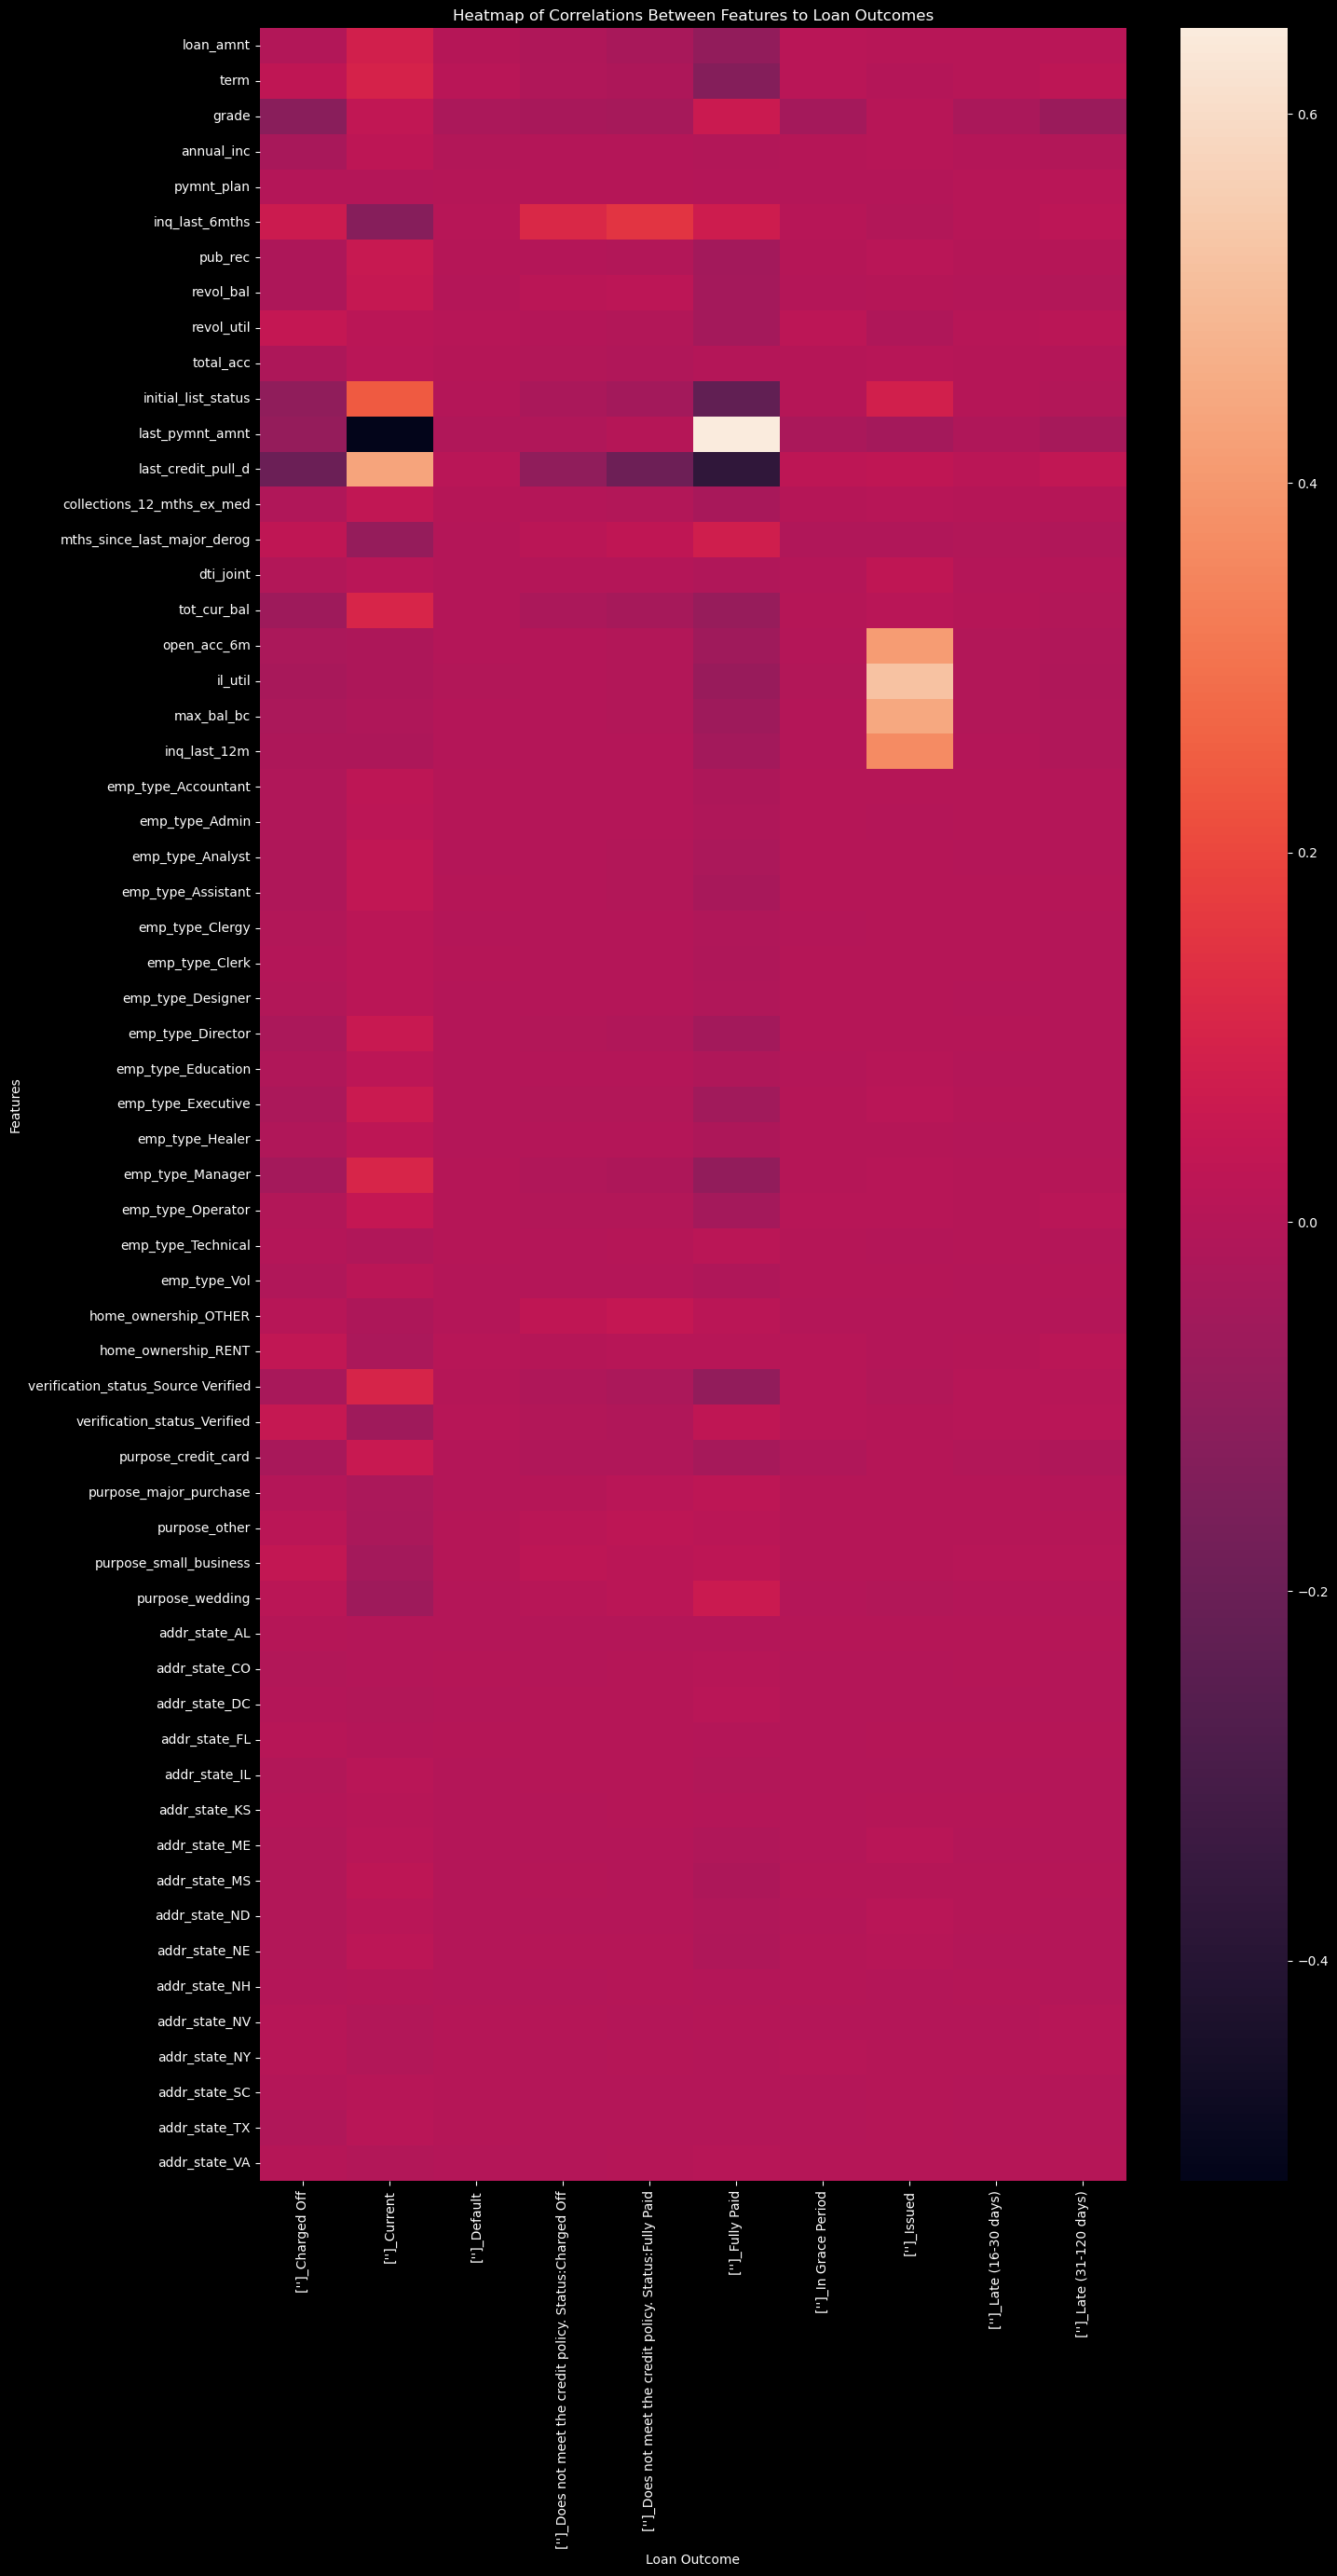

In [21]:
# create a matrix that stores each of the correlations between the clusters and labels
corr_matrix = np.zeros((10,61))

# Create dummy variables for all the different intrusion types.
y_dummy = pd.get_dummies(y, prefix = [''])

# combine the y-dummy with the rest of the dataset
lab_dummy = pd.concat([data, y_dummy], axis = 1) 

# loop over the clusters
for k in tqdm(range(61)):
    # Loop over the different labels
    for label in range(61,71):
        # Assign each part of the matrix the correlation between label and cluster
        corr_matrix[label-61, k] = lab_dummy.iloc[:,k].T.corr(other = lab_dummy.iloc[:,label])

# Turn the correlation matrix into a dataframe so it will be easier to manipulate
corr_df = pd.DataFrame(corr_matrix,
                       columns = lab_dummy.columns[:61],
                       index = lab_dummy.columns[61:])
     
#Back to darkmode for the eyes
plt.style.use('dark_background')
# Change the figure size so that all the intrusions types are legible
plt.figure(figsize = (15,30))
# Create a heatmap of correlation matrix to see each clusters highest intrusion correlations
sns.heatmap(corr_df.T);
# Label the axes
plt.xlabel("Loan Outcome");
plt.ylabel("Features");
# Give a title
plt.title("Heatmap of Correlations Between Features to Loan Outcomes");

In [22]:
y.value_counts(normalize = True)

Current                                                0.678153
Fully Paid                                             0.234086
Charged Off                                            0.050991
Late (31-120 days)                                     0.013062
Issued                                                 0.009534
In Grace Period                                        0.007047
Late (16-30 days)                                      0.002656
Does not meet the credit policy. Status:Fully Paid     0.002240
Default                                                0.001374
Does not meet the credit policy. Status:Charged Off    0.000858
Name: loan_status, dtype: float64

In [ ]:
# Create the PCA object since the data has already been scaled
pca = PCA(n_components = 2)
# create a data frame pca_vectors that has the two pca components 
pca_vectors = pd.DataFrame(pca.fit_transform(X), columns = ['1','2'])
# Combine the 2 components and the cluster that the label is a part of
pca_vectors = pd.concat([pca_vectors, cluster_labels], axis = 1)